In [0]:
!pip install lightgbm
%restart_python

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/4e/19/1b928cad70a4e1a3e2c37d5417ca2182510f2451eaadb6c91cd9ec692cae/lightgbm-4.5.0-py3-none-manylinux_2_28_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/3.6 MB ? eta -:--:--
   ━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.1/3.6 MB 3.4 MB/s eta 0:00:02
   ━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.4/3.6 MB 6.2 MB/s eta 0:00:01
   ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.8/3.6 MB 7.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/3.6 MB 9.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 1.8/3.6 MB 10.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━ 2.5/3.6 MB 12.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━ 3.0/3.6 MB 13.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 3.5/3.6 MB 13.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 11.9 MB/s eta 0:00:00
Note: you may need to r

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, sum as spark_sum, count, row_number, desc, dayofweek, to_timestamp, date_format, max as spark_max, min as spark_min, to_date, concat_ws
from pyspark.sql.window import Window

import os

In [0]:
spark = (
    SparkSession.builder
    .appName("picpay-case")
    .getOrCreate()
)

In [0]:
df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/victorabatistella@gmail.com/airports_database.csv")
df = df.dropDuplicates()
count_total = df.count()
print(count_total)
df.show(2)

336776
+---+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+--------------------+
| id|year|month|day|dep_time|sched_dep_time|dep_delay|arr_time|sched_arr_time|arr_delay|carrier|flight|tailnum|origin|dest|air_time|distance|hour|minute|          time_hour|                name|
+---+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+--------------------+
|  2|2013|    1|  1|   542.0|           540|      2.0|   923.0|           850|     33.0|     AA|  1141| N619AA|   JFK| MIA|   160.0|    1089|   5|    40|2013-01-01 05:00:00|American Airlines...|
|  1|2013|    1|  1|   533.0|           529|      4.0|   850.0|           830|     20.0|     UA|  1714| N24211|   LGA| IAH|   227.0|    1416|   5|    29|2013-01-01 05:00:00|United Air Lines ...|
+---+----+-----+--

## 1. Qual é o número total de voos no conjunto de dados?

In [0]:
print(df.count())

336776


**Resposta:** 336.776 voos total

## 2. Quantos voos foram cancelados?

In [0]:
cancelados = (
  df
  .filter(col("dep_time").isNull())
  .filter(col("arr_time").isNull())
)
print(cancelados.count())
print(cancelados.count() / count_total * 100)

8255
2.451184169893341


**Resposta**: 8.255 voos cancelados ou 2,45%

## 3. Qual é o atraso médio na partida dos voos?

In [0]:
atraso =  (
  df
  .select(
    avg(col("dep_delay"))
  )
).collect()[0][0]
print(atraso)

12.639070257304708


**Resposta:** 12.63 minutos

## 4. Quais são os 5 aeroportos com maior número de pousos?

In [0]:
window_spec = Window.orderBy(desc(col("total_destiny")))
top_5_dest_airports = (
    df
    .filter(col("dep_time").isNotNull())
    .filter(col("arr_time").isNotNull())
    .groupBy(col("dest"))
    .agg(count(col("id")).alias("total_destiny"))
    .withColumn("row_number", row_number().over(window_spec))
    .filter(col("row_number") <= 5)
    .drop("row_number")
)
top_5_dest_airports.show()

+----+-------------+
|dest|total_destiny|
+----+-------------+
| ATL|        16873|
| ORD|        16607|
| LAX|        16058|
| BOS|        15028|
| MCO|        13979|
+----+-------------+



**Resposta:**
1. **ATL:** 16.873
2. **BOS:** 16.607
3. **LAX:** 16.058
4. **BOS:** 15.028
5. **MCO:** 13.979

OBS.: Como não há pouso se o voo foi cancelado, esses foram removidos da conta.

## 5. Qual é a rota mais frequente?

In [0]:
window_spec = Window.orderBy(desc(col("total_route")))
top_route = (
    df
    .groupBy(col("origin"), col("dest"))
    .agg(count(col("id")).alias("total_route"))
    .withColumn("row_number", row_number().over(window_spec))
    .filter(col("row_number") <= 5)
    .drop("row_number")
)
top_route.show()

+------+----+-----------+
|origin|dest|total_route|
+------+----+-----------+
|   JFK| LAX|      11262|
|   LGA| ATL|      10263|
|   LGA| ORD|       8857|
|   JFK| SFO|       8204|
|   LGA| CLT|       6168|
+------+----+-----------+



**Resposta:** JFK -> LAX com 11.262 voos.

## 6. Quais são as 5 companhias aéreas com maior tempo médio de atraso na chegada?

In [0]:
window_spec = Window.orderBy(desc(col("avg_delay")))
top_delay = (
    df
    .groupBy(col("carrier"))
    .agg(avg(col("arr_delay")).alias("avg_delay"))
    .withColumn("row_number", row_number().over(window_spec))
    .filter(col("row_number") <= 5)
    .drop("row_number")
)
top_delay.show()

+-------+------------------+
|carrier|         avg_delay|
+-------+------------------+
|     F9|21.920704845814978|
|     FL|20.115905511811025|
|     EV| 15.79643108710965|
|     YV|15.556985294117647|
|     OO|11.931034482758621|
+-------+------------------+



**Resposta:**
1. **F9:** 21,92 minuntos
2. **FL:** 20,11 minuntos
3. **EV:** 15,79 minuntos
4. **YV:** 15,55 minuntos
5. **OO:** 11,93 minuntos

## 7. Qual é o dia da semana com maior número de voos?

In [0]:
top_weekday = (
    df
    .select("id", "time_hour")
    .withColumn("time_hour", to_timestamp("time_hour", "yyyy-MM-dd HH:mm:ss"))
    .withColumn("weekday", dayofweek("time_hour"))
    .withColumn("weekday_name", date_format("time_hour", "EEEE"))
    .groupBy(col("weekday"), col("weekday_name"))
    .agg(count(col("id")).alias("total_flights"))
    .orderBy(desc(col("total_flights")))
)
top_weekday.show()

+-------+------------+-------------+
|weekday|weekday_name|total_flights|
+-------+------------+-------------+
|      2|      Monday|        50690|
|      3|     Tuesday|        50422|
|      6|      Friday|        50308|
|      5|    Thursday|        50219|
|      4|   Wednesday|        50060|
|      1|      Sunday|        46357|
|      7|    Saturday|        38720|
+-------+------------+-------------+



**Resposta**: O dia da semana com maior número de voos é Segunda com 50.690 voos.

## 8. Qual o percentual mensal dos voos tiveram atraso na partida superior a 30 minutos?

In [0]:
total_flights_per_month = (
    df
    .groupBy("month")
    .agg(count("id").alias("total_flights"))
)

delay_30_per_month = (
    df
    .filter(col("dep_delay") >= 30)
    .groupBy("month")
    .agg(count("id").alias("delay_30_flights"))
)

perc_delay_sup_30m_per_month = (
    total_flights_per_month
    .join(
        delay_30_per_month, 
        on="month", 
        how="left"
    )
    .fillna(0)
    .withColumn("percetage", (col("delay_30_flights") / col("total_flights")) * 100)
    .drop("total_flights")
    .drop("delay_30_flights")
    .orderBy(desc(col("month")))
)
perc_delay_sup_30m_per_month.show()

+-----+------------------+
|month|         percetage|
+-----+------------------+
|    9| 8.961340393123958|
|    8| 14.78501039997272|
|    7|21.389974511469838|
|    6|20.575009736925963|
|    5|15.745242394777053|
|    4|16.321920225908933|
|    3|15.266699035860443|
|    2|13.085647869824857|
|   12|17.831881997511996|
|   11|  9.03256564471175|
|   10| 9.581501609609195|
|    1| 12.69441564212709|
+-----+------------------+



**Resposta**: 
1. Janeiro: 12.69%
2. Fevereiro: 13.09%
3. Março: 15.27%
4. Abril: 16.32%
5. Maio: 15.75%
6. Junho: 20.58%
7. Julho: 21.39%
8. Agosto: 14.79%
9. Setembro: 8.96%
10. Outubro: 9.58%
11. Novembro: 9.03%
12. Dezembro: 17.83%

## 9. Qual a origem mais comum para voos que pousaram em Seattle (SEA)?

In [0]:
window_spec = Window.orderBy(desc(col("count_origin")))
seattle_origin = (
    df
    .filter(col("dest") == "SEA")
    .groupBy(col("origin"))
    .agg(count(col("id")).alias("count_origin"))
    .withColumn("row_number", row_number().over(window_spec))
    .filter(col("row_number") <= 5)
    .drop("row_number")
)
seattle_origin.show()

+------+------------+
|origin|count_origin|
+------+------------+
|   JFK|        2092|
|   EWR|        1831|
+------+------------+



**Resposta**: A origem mais comum para voos para Seattle é JFK

## 10. Qual é a média de atraso na partida dos voos (dep_delay) para cada dia da semana?

In [0]:
delay_avg_weekday = (
    df
    .withColumn("time_hour", to_timestamp("time_hour", "yyyy-MM-dd HH:mm:ss"))
    .withColumn("weekday", dayofweek("time_hour"))
    .withColumn("weekday_name", date_format("time_hour", "EEEE"))
    .groupBy(col("weekday"), col("weekday_name"))
    .agg(avg(col("dep_delay")).alias("avg_delay"))
    .orderBy(desc(col("avg_delay")))
)
delay_avg_weekday.show()

+-------+------------+------------------+
|weekday|weekday_name|         avg_delay|
+-------+------------+------------------+
|      5|    Thursday|16.148919990957108|
|      2|      Monday|14.778936729330908|
|      6|      Friday| 14.69605749486653|
|      4|   Wednesday|11.803512219083876|
|      1|      Sunday|11.589531801152422|
|      3|     Tuesday|10.631682565455652|
|      7|    Saturday| 7.650502333676133|
+-------+------------+------------------+



**Resposta**:
1. Domingo: 11.59 minutos
2. Segunda: 14.78 minutos
3. Terça: 10.63 minutos
4. Quarta: 11.80 minutos
5. Quinta: 16.15 minutos
6. Sexta: 14.70 minutos
7. Sábado: 7.65 minutos

## 11. Qual é a rota que teve o maior tempo de voo médio (air_time)?

In [0]:
window_spec = Window.orderBy(desc(col("avg_air_time")))
top_airtime_route = (
    df
    .withColumn("air_time", col("air_time").cast("float"))
    .groupBy(col("origin"), col("dest"))
    .agg(avg(col("air_time")).alias("avg_air_time"))
    .withColumn("row_number", row_number().over(window_spec))
    .filter(col("row_number") <= 5)
    .drop("row_number")
)
top_airtime_route.show()

+------+----+-----------------+
|origin|dest|     avg_air_time|
+------+----+-----------------+
|   JFK| HNL|623.0877192982456|
|   EWR| HNL| 612.075208913649|
|   EWR| ANC|          413.125|
|   JFK| SFO|347.4036256011839|
|   JFK| SJC|346.6067073170732|
+------+----+-----------------+



**Resposta**: JFK -> HNL com 623 minutos de voo

## 12. Para cada aeroporto de origem, qual é o aeroporto de destino mais comum?

In [0]:
window_spec = Window.partitionBy("origin").orderBy(desc("total_route"))
top_route = (
    df
    .groupBy(col("origin"), col("dest"))
    .agg(count(col("id")).alias("total_route"))
    .withColumn("row_number", row_number().over(window_spec))
    .filter(col("row_number") == 1)
    .drop("row_number")
)
top_route.show()

+------+----+-----------+
|origin|dest|total_route|
+------+----+-----------+
|   EWR| ORD|       6100|
|   JFK| LAX|      11262|
|   LGA| ATL|      10263|
+------+----+-----------+



**Resposta**: 
1. EWR -> ORD com 6.100 voos
2. JFK -> LAX com 11.262 voos
3. LGA -> ATL com 10.263 voos

## 13. Quais são as 3 rotas que tiveram a maior variação no tempo médio de voo (air_time) ?

In [0]:
window_spec = Window.orderBy(desc(col("diff_air_time")))
top_diff_routes = (
    df
    .withColumn("air_time", col("air_time").cast("float"))
    .groupBy(col("origin"), col("dest"))
    .agg(
      spark_max(col("air_time")).alias("max_air_time"),
      spark_min(col("air_time")).alias("min_air_time"),
    )
    .withColumn("diff_air_time", col("max_air_time")-col("min_air_time"))
    .withColumn("row_number", row_number().over(window_spec))
    .filter(col("row_number") <= 3)
    .drop("max_air_time", "min_air_time", "row_number")
)
top_diff_routes.show()

+------+----+-------------+
|origin|dest|diff_air_time|
+------+----+-------------+
|   JFK| SFO|        189.0|
|   JFK| LAX|        165.0|
|   JFK| EGE|        163.0|
+------+----+-------------+



**Resposta**:
1. JFK -> SFO: 189 minutos de diferença
2. JFK -> LAX: 165 minutos de diferença
3. JFK -> EGE: 163 minutos de diferença

## 14. Qual é a média de atraso na chegada para voos que tiveram atraso na partida superior a 1 hora?

In [0]:
avg_arr_delay_dep_sup_1h = (
    df
    .filter(col("dep_delay") >= 60)
    .select(avg(col("arr_delay")))
)
avg_arr_delay_dep_sup_1h.show()

+------------------+
|    avg(arr_delay)|
+------------------+
|117.94679501529737|
+------------------+



**Resposta:** 117,94 minutos de atras em média

## 15. Qual é a média de voos diários para cada mês do ano?

In [0]:
avg_daily_flights = (
    df
    .groupBy(col("day"), col("month"))
    .agg(count("id").alias("n_voos"))
    .withColumn("month", col("month").cast("int"))
    .groupBy(col("month"))
    .agg(avg("n_voos").alias("avg_n_voos_monthly"))
    .orderBy(col("month"))
)
avg_daily_flights.show()

+-----+------------------+
|month|avg_n_voos_monthly|
+-----+------------------+
|    1| 871.0967741935484|
|    2| 891.1071428571429|
|    3| 930.1290322580645|
|    4| 944.3333333333334|
|    5| 928.9032258064516|
|    6| 941.4333333333333|
|    7| 949.1935483870968|
|    8| 946.0322580645161|
|    9| 919.1333333333333|
|   10| 931.9032258064516|
|   11| 908.9333333333333|
|   12| 907.5806451612904|
+-----+------------------+



**Resposta**:
1. Janeiro: 871.10 em média de voos diários
2. Fevereiro: 891.11 em média de voos diários
3. Março: 930.13 em média de voos diários
4. Abril: 944.33 em média de voos diários
5. Maio: 928.90 em média de voos diários
6. Junho: 941.43 em média de voos diários
7. Julho: 949.19 em média de voos diários
8. Agosto: 946.03 em média de voos diários
9. Setembro: 919.13 em média de voos diários
10. Outubro: 931.90 em média de voos diários
11. Novembro: 908.93 em média de voos diários
12. Dezembro: 907.58 em média de voos diários

## 16. Quais são as 3 rotas mais comuns que tiveram atrasos na chegada superiores a 30 minutos?

In [0]:
top_3_routes_30m_delay = (
    df
    .groupBy(col("origin"), col("dest"))
    .agg(
        count("id").alias("n_voos"),
        spark_max("arr_delay").alias("max_delay")
    )
    .filter(col("max_delay") >= 30)
    .orderBy(col("n_voos").desc())
    .limit(3)
    .drop("n_voos", "max_delay")
)
top_3_routes_30m_delay.show()

+------+----+
|origin|dest|
+------+----+
|   JFK| LAX|
|   LGA| ATL|
|   LGA| ORD|
+------+----+



**Resposta**:
1. JFK -> LAX
2. LGA -> ATL
3. LGA -> ORD

## 17. Para cada origem, qual o principal destino?

In [0]:
window_spec = Window.partitionBy("origin").orderBy(desc("total_route"))
origin_dest_top = (
    df
    .groupBy(col("origin"), col("dest"))
    .agg(count(col("id")).alias("total_route"))
    .withColumn("row_number", row_number().over(window_spec))
    .filter(col("row_number") == 1)
    .drop("row_number")
)
origin_dest_top.show()

+------+----+-----------+
|origin|dest|total_route|
+------+----+-----------+
|   EWR| ORD|       6100|
|   JFK| LAX|      11262|
|   LGA| ATL|      10263|
+------+----+-----------+



**Resposta**: 
1. EWR -> ORD com 6.100 voos
2. JFK -> LAX com 11.262 voos
3. LGA -> ATL com 10.263 voos

# Feature Engineering

In [0]:
import requests
import time

## Get Airpot data

In [0]:
def get_airport_data(airport, wait_time=0.5):
    airportdb_key = 'API_KEY'
    url =f"https://airportdb.io/api/v1/airport/K{airport}?apiToken={airportdb_key}"
    response = requests.get(url)
    data = response.json()
    time.sleep(wait_time)
    return data


In [0]:
distinct_airport = df.select("origin").distinct().collect()

data = []
for a in distinct_airport:
    airport = a["origin"]
    item = get_airport_data(airport)
    data.append(
        {
            "airport": airport,
            "latitude_deg": item["latitude_deg"], 
            "longitude_deg": item["longitude_deg"]
        }
    )

airport_df = spark.createDataFrame(data)

In [0]:
airport_df.show()

+-------+------------+-------------+
|airport|latitude_deg|longitude_deg|
+-------+------------+-------------+
|    LGA|   40.777199|   -73.872597|
|    EWR|   40.692501|   -74.168701|
|    JFK|   40.639801|     -73.7789|
+-------+------------+-------------+



## Get Weather data

In [0]:
weather_df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/victorabatistella@gmail.com/weather_data.csv")
weather_df = weather_df.withColumn("datetime", to_date("datetime", "yyyy-MM-dd"))
weather_df.show()

+------+----------+--------------------+---+---+---+-------+-------+-------+--------+-----------+------------------+------------+------------+---------------+-------------------+-----------+------+----------+----+---------------+---+----+----+----------+---------+-----+-----+-----+-----------+----+----------+--------+-------------+--------+-------+
|clouds|  datetime|               dewpt|dhi|dni|ghi|max_dhi|max_dni|max_ghi|max_temp|max_temp_ts|            max_uv|max_wind_dir|max_wind_spd|max_wind_spd_ts|           min_temp|min_temp_ts|precip|precip_gpm|pres|revision_status| rh| slp|snow|snow_depth|solar_rad|t_dhi|t_dni|t_ghi|t_solar_rad|temp|        ts|wind_dir|wind_gust_spd|wind_spd|airport|
+------+----------+--------------------+---+---+---+-------+-------+-------+--------+-----------+------------------+------------+------------+---------------+-------------------+-----------+------+----------+----+---------------+---+----+----+----------+---------+-----+-----+-----+-----------+----

## Feature Dataset

In [0]:
features_df = (
    df
    .withColumn("date", to_date(col("time_hour"), "yyyy-MM-dd HH:mm:ss"))
    .join(
        weather_df, 
        on=(col("date") == col("datetime")) & (col("origin") == col("airport")),
        how="left"
    )
    .select(
        col("sched_dep_time"),
        col("sched_arr_time"),
        col("distance"),
        col("clouds"),
        col("pres"),
        col("wind_spd"),
        col("precip"),
        col("snow"),
        col("dep_delay"),
    )
    .filter(col("dep_delay").isNotNull())
)

features_df.show()

+--------------+--------------+--------+------+----+--------+------+----+---------+
|sched_dep_time|sched_arr_time|distance|clouds|pres|wind_spd|precip|snow|dep_delay|
+--------------+--------------+--------+------+----+--------+------+----+---------+
|           540|           850|    1089|    96|1012|     6.8|   0.0| 0.0|      2.0|
|           600|           910|    1389|    91|1011|     6.9|   0.0| 0.0|     -1.0|
|           600|           825|     762|    91|1011|     6.9|   0.0| 0.0|      0.0|
|           559|           706|     187|    96|1012|     6.8|   0.0| 0.0|      0.0|
|           600|           937|    2565|    93|1011|     5.8|   0.0| 0.0|     -2.0|
|           600|           902|    2227|    93|1011|     5.8|   0.0| 0.0|     -1.0|
|           600|           851|    1028|    96|1012|     6.8|   0.0| 0.0|     -2.0|
|           600|           856|    1005|    96|1012|     6.8|   0.0| 0.0|     -2.0|
|           600|           846|     944|    96|1012|     6.8|   0.0| 0.0|   

# Train model

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import pickle
import numpy as np

## Prepare X and Y

In [0]:
features = features_df.toPandas()
# Divide into X an Y
X = features.drop(columns=["dep_delay"])
y = features["dep_delay"]

## Treat Null values on X

In [0]:
# Add median to Null and NaN values
imputer = SimpleImputer(strategy='median') 
X_imputed = imputer.fit_transform(X)

## Normalize

In [0]:
# Normalize X
x_scaler = StandardScaler()
X_normalized = x_scaler.fit_transform(X_imputed)

# Normalize Y
y_scaler = StandardScaler()
y_normalized = y_scaler.fit_transform(y.values.reshape(-1, 1))

## Split Dataset

In [0]:
# Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized.ravel(), test_size=0.2, random_state=42) 

# Create lightgbm dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

## Train

In [0]:
# Hyperparameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'n_estimators': 100,
}

# Train model
model = lgb.train(
    params, 
    train_data, 
    num_boost_round=1000,
    valid_sets=[test_data]
)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-fb52e55e-2545-4b28-9d62-a32e0e10b9e7/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1058
[LightGBM] [Info] Number of data points in the train set: 262816, number of used features: 8
[LightGBM] [Info] Start training from score 0.000371


## Commom metrics for Regression

In [0]:
# Predict on test data
y_pred = model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Calculate R2
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

MAE: 0.49211104228445735
MSE: 0.8070401750502565
RMSE: 0.8983541479006242
R²: 0.1816685563264343


## Feature Importance

          Feature  Importance
3          clouds         550
4            pres         504
5        wind_spd         478
2        distance         396
6          precip         385
0  sched_dep_time         383
7            snow         189
1  sched_arr_time         115


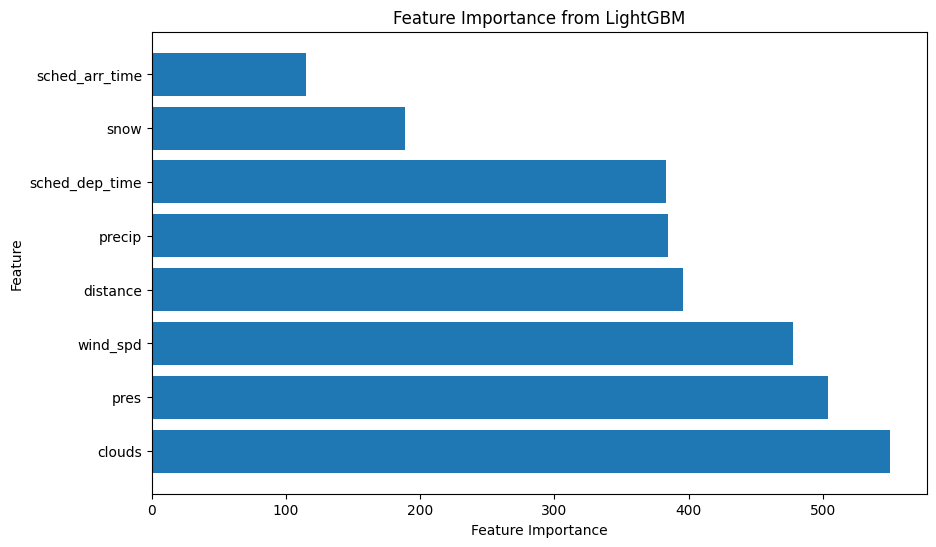

In [0]:
import matplotlib.pyplot as plt

feature_importance = model.feature_importance()

feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})


feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from LightGBM')
plt.show()


## Save model as pickle

In [0]:
dbutils.fs.ls("/FileStore/shared_uploads/victorabatistella@gmail.com/")


[FileInfo(path='dbfs:/FileStore/shared_uploads/victorabatistella@gmail.com/airports_database.csv', name='airports_database.csv', size=42858599, modificationTime=1733324108000),
 FileInfo(path='dbfs:/FileStore/shared_uploads/victorabatistella@gmail.com/weather_data-1.json', name='weather_data-1.json', size=1016034, modificationTime=1734270263000),
 FileInfo(path='dbfs:/FileStore/shared_uploads/victorabatistella@gmail.com/weather_data-2.json', name='weather_data-2.json', size=1015722, modificationTime=1734270365000),
 FileInfo(path='dbfs:/FileStore/shared_uploads/victorabatistella@gmail.com/weather_data.csv', name='weather_data.csv', size=208181, modificationTime=1734270508000),
 FileInfo(path='dbfs:/FileStore/shared_uploads/victorabatistella@gmail.com/weather_data.json', name='weather_data.json', size=1016034, modificationTime=1734270121000)]

In [0]:
import pickle
import base64

models_dict = {
    'model': model,
    'x_scaler': x_scaler,
    'y_scaler': y_scaler
}

serialized_object = base64.b64encode(pickle.dumps(models_dict)).decode('utf-8')


file_path = "dbfs:/FileStore/shared_uploads/victorabatistella@gmail.com/model.pkl"
dbutils.fs.put(file_path, serialized_object, overwrite=True)

displayHTML('<a href="/files/shared_uploads/victorabatistella@gmail.com/model.pkl" download>Download Pickle</a>')


Wrote 399852 bytes.


Download Pickle